# Explorador de um mapa - Observando diferentes regiões

## Imports & Setups

In [1]:
import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

# Imports do pacote do projeto
from gcm.core import Config, GloballyCoupledMaps
from gcm.maps import bistable_intervals, sync_boundaries
from gcm.metrics import sigma as sigma_metric, spins, magnetization

# Paleta (igual pedida)
COL_NON_SYNC  = "#e09f3e"   # não sincronizado
COL_SYNC_STAT = "#335c67"   # síncrono estacionário
COL_SYNC_CHAOS= "#9fd356"   # síncrono caótico
COL_ESCAPE    = "#9e2a2b"   # escape

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

MU_MAIN = 1.9     # μ do artigo (biestável e caótico local)
I_TRACKS = [0, 1, 2, 3]  # índices que vamos olhar nos exemplos com múltiplas trajetórias


def fprime_piecewise(x, mu):
    """f'(x;mu): μ no miolo (|x|<1/3), -μ nas abas (|x|≥1/3)."""
    x = np.asarray(x)
    return np.where(np.abs(x) < 1.0/3.0, mu, -mu)


def estimate_lambda_local(x_series, mu):
    """λ_est ≈ mean_t ln|f'(x_t)| (tempo finito). Para este mapa, ~ ln|μ|."""
    fp = fprime_piecewise(x_series, mu)
    return float(np.mean(np.log(np.abs(fp))))

def shade_Ipm(ax, mu, alpha=0.12):
    """Sombras das bandas I_- e I_+ quando 1<μ<2 (apoio visual)."""
    if 1.0 < abs(mu) < 2.0:
        (imin, imax), (jmin, jmax) = bistable_intervals(mu)
        ax.axhspan(imin, imax, alpha=alpha, color="k")
        ax.axhspan(jmin, jmax, alpha=alpha, color="k")


def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp

def run_custom_init(mu, eps, x0, T_burn=0, T_meas=400, seed=0):
    """Roda o sistema começando de um vetor x0 dado (bypass do reset). Retorna (traj, sys)."""
    cfg = Config(N=len(x0), eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.x = np.array(x0, dtype=float)
    if T_burn>0:
        sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys


def run_track_including_initial(cfg, init_kind="half_half", x0=None, T=400, seed=None):
    """
    Executa e retorna uma matriz (T+1, N) que INCLUI o estado inicial na linha 0.
    Se x0 for fornecido, usa-o diretamente; caso contrário, chama reset(init_kind).
    """
    from gcm.core import GloballyCoupledMaps
    sys = GloballyCoupledMaps(cfg)
    if x0 is None:
        sys.reset(init=init_kind)
    else:
        sys.x = np.array(x0, dtype=float)
    N = sys.x.size
    hist = np.empty((T+1, N), dtype=float)
    hist[0] = sys.x.copy()
    for t in range(T):
        sys.step()
        hist[t+1] = sys.x.copy()
    return hist, sys


## Parte A - Síncrono estacionário ($\mu$=0.8)

> Dois mapas $x_i(t)$ com diferentes condições iniciais convergem para o mesmo valor fixo (teoricamente). Observamos isso na simulação e comparamos $\lambda$ teórico e estimado.

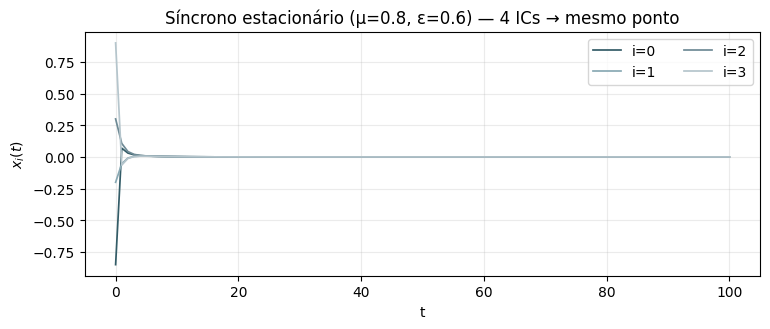

[A] λ_teo=-0.223144  λ_est=-0.223144  λ_perp=-1.139434


In [6]:
# ----- Síncrono estacionário (μ<1) -----
MU_STAT = 0.8
EPS_STAT = 0.6
N = 64
# x0: quatro pontos bem distintos, resto aleatório (não influencia a convergência)
rng = np.random.default_rng(42)
x0 = rng.uniform(-1, 1, size=N)
x0[:4] = np.array([-0.85, -0.2, 0.3, 0.9])  # os quatro que vamos plotar

from gcm.core import Config
cfg_stat = Config(N=N, eps=EPS_STAT, mu=MU_STAT, seed=123)

# Trajetória incluindo t=0 = x0
trajA, sysA = run_track_including_initial(cfg_stat, x0=x0, T=100)
lines = []

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7.8, 3.4))
cols = ["#335c67", "#89a9b4", "#6e8a95", "#b5c5cc"]  # variações coerentes com COL_SYNC_STAT
for k, c in zip(range(4), cols):
    ln, = ax.plot(trajA[:, k], lw=1.25, color=c, label=f"i={k}")
    lines.append(ln)

# λ teórico/estimado/⊥ (usa uma das séries para λ_est)
lam_teo, lam_est, lam_perp = lambdas(MU_STAT, EPS_STAT, trajA[:, 0])
info_label = rf"λ={lam_teo:.3f} (teo) / {lam_est:.3f} (est) —  λ⊥={lam_perp:.3f}"
# “linha invisível” só para levar texto à legenda
from matplotlib.lines import Line2D
lines.append(Line2D([], [], color='none', label=info_label))

ax.set_title(rf"Síncrono estacionário (μ={MU_STAT}, ε={EPS_STAT}) — 4 ICs → mesmo ponto")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
#ax.set_yscale("log")
ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"A_sync_estacionario_quatro_ICs.png", dpi=180); plt.show()

print(f"[A] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}")



**Leitura rápida do gráfico:** 

Como já vimos, no notebook passado, para $|\mu|<1$ uma faixa de $\varepsilon$ considerável próxima de 1 nos faz estar dentro da zona de sincronia **estacionária**, i.e., todos convergem para o mesmo valor de $x$, que chamemos de $x*$. Além disso, podevemos nos resultados que ambos, $\lambda_{est}$ e $\lambda_{\perp}$ são negativos. O modo perpendicular ser negativo, indica que estamos na sincronia, como esperado, enquanto $\lambda_{est}$ ser negativo, nos indica que se trata de uma sincronia **estacionária**.


O que podemos entender: Se $|\mu|<1$ o mapa local tende a contrair, i.e, suprimir o seu valor ao longo do tempo, como se o átomo não enxerguasse mais os seus vizinhos para alterar seu estado de energia. Além disso, para haver algum disturbio provocado a força de acoplameto global deve ser muito grande, para compensar o fato de que $\mu$ é pequeno. É claro que quando menor $\mu$ maior deve ser $\varepsilon$ para compensar.
 
No gráfico acima, o que observamos, é o comportamento de 4 trajetórias específicas $x_i^{t}$ com condições iniciais bem diferentes. O que observamos é que todas elas, para esse valor de $\varepsilon$ e $\mu$ convergem para o mesmo valor de $x$ que é $x*=0$.

## Parte B -- Síncrono caótico ($\mu=1.9$)

> Mostramos duas execuções com $\varepsilon$ na banda **sincronizada** de forma que observemos os dois atratores $I_+$ e $I_-$ (todos sincronizando em um atrator caótico). 

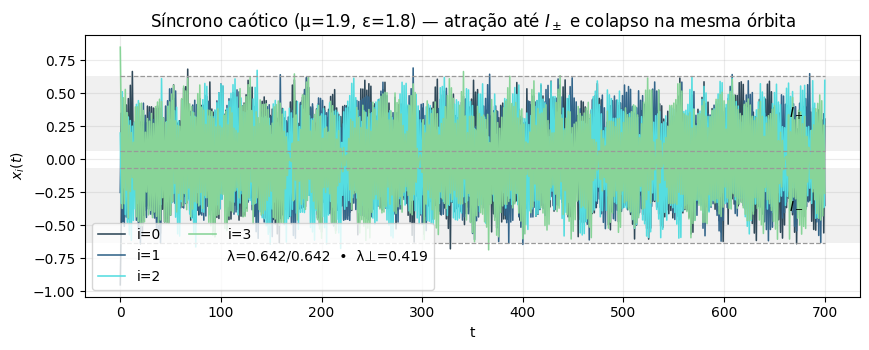

[B] λ_teo=0.641854  λ_est=0.641854  λ_perp=0.418710; com I_-=(-0.6333333333333333, -0.0633333333333334); I_+ = (0.0633333333333334, 0.6333333333333333)


In [12]:
# ----- Síncrono caótico (μ>1) -----
MU = 1.9
EPS_SC = 1.8# dentro da banda (sincroniza)
N = 512
T = 700

from gcm.maps import bistable_intervals
i_minus, i_plus = bistable_intervals(MU)

def make_ic_far_from_attractors(N, seed=7):
    rng = np.random.default_rng(seed)
    x0 = rng.uniform(-1.0, 1.0, size=N)
    # garanta alguns pontos “distantes” dos intervalos, para visual
    x0[0] = -0.95   # bem negativo
    x0[1] = -0.25   # miolo negativo
    x0[2] =  0.20   # miolo positivo
    x0[3] =  0.85   # bem positivo
    return x0

cfg_sc = Config(N=N, eps=EPS_SC, mu=MU, seed=1001)
x0_sc = make_ic_far_from_attractors(N, seed=1001)
trajB, sysB = run_track_including_initial(cfg_sc, x0=x0_sc, T=T)

fig, ax = plt.subplots(figsize=(8.8, 3.6))
colsB = ["#2f4858", "#33658a", "#55dde0", "#88d498"]
for k, c in zip([0,1,2,3], colsB):
    ax.plot(trajB[:, k], lw=1.15, color=c, label=f"i={k}")

# Evidencia I_- e I_+ com linhas horizontais e sombreamento
ax.hlines([i_minus[0], i_minus[1]], xmin=0, xmax=T, colors="#999999", linestyles="--", lw=0.9)
ax.hlines([i_plus[0],  i_plus[1]],  xmin=0, xmax=T, colors="#999999", linestyles="--", lw=0.9)
ax.axhspan(i_minus[0], i_minus[1], color="k", alpha=0.06, linewidth=0)
ax.axhspan(i_plus[0],  i_plus[1],  color="k", alpha=0.06, linewidth=0)
ax.text(T*0.97, np.mean(i_plus),  r"$I_+$", ha="right", va="center")
ax.text(T*0.97, np.mean(i_minus), r"$I_-$", ha="right", va="center")

# λs
lam_teo, lam_est, lam_perp = lambdas(MU, EPS_SC, trajB[:, 0])
info = Line2D([], [], color='none', label=rf"λ={lam_teo:.3f}/{lam_est:.3f}  •  λ⊥={lam_perp:.3f}")

ax.set_title(rf"Síncrono caótico (μ={MU}, ε={EPS_SC}) — atração até $I_\pm$ e colapso na mesma órbita")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
ax.legend(handles=[*ax.get_lines(), info], loc="best", ncol=2, frameon=True)

fig.tight_layout(); fig.savefig(FIGS/"B_sync_caotico_sem_burn_Ipm.png", dpi=180); plt.show()
print(f"[B] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}; com I_-={i_minus}; I_+ = {i_plus}")


**Intepretação do gráfico: Por que dois atratores?** 

Observamos que, diferentemente do caso anterior, temos $\lambda_{est}>0$ enquanto mantemos $\lambda_{\perp}<0$. O que isso significa?

Significa que os modos transversais estão sendo suprimidos ainda, devido ao valor próximo de 1 de $\epsilon$. Entretanto, como o mapa local possui grande força, diferente do caso anterior, ou seja, $|\mu|>1$, temos um regime caótico, no qual o sistema tende a um dos dois atratores $I_+$ ou e $I_-$ dados por:


$$I_{\pm}=[\pm \mu(2-\mu)/3, \pm \mu/3]$$

O sistema fica em uma órbita caótica e, com o passar do tempo, tende a um dos dois atratores [MUdando as condições iniciais somos jogados ou para $I_+$ ou para $I_-$]. O acomplamento global faz com que todos os sistemas sigam a mesma órbita para tempos grandes, enquanto a força grande do mapa local não permite que o sistema entre em um estado totalmente estacionário em um valor único de x.

Entretanto, note: Todos os $x_i$ tendem a seguir a mesma órbita com o passar do tempo, mesmo que o sistema seja caótico podemos prever o que todos os mapas vão fazer no próximo passo. Isso nos diz algo importante que já vimos: O caos não é sinônimo de aleatoriedade e pode ser previsível.

Em resumo:
Para $ |\mu |>1$ e dentro da banda síncrona, entramos na síncronia caótica. O mapa local é **biestável**. 

O que isso significa? Existem dois atratores $I_{\pm}=[\pm \mu(2-\mu)/3, \pm \mu/3]$ que levam $x^{t}$ nessa direção ao longo do tempo. 

Diferente do caso anterior, o mapa local é forte o suficiente para que os átomos sempre vejam seus vizinhos e isso gera instabilidade. Ao mesmo tempo, por existir uma força global $\epsilon$, todos convergem para o mesmo regime caótico e um dos atratores vence.

Ou seja, a tendência global alinha todos para seguir a mesma órbita, enquanto o mapa local faz com que o caminho seguido por todos fique tortuoso e caótico. Assim como antes, por $\mu$ ser maior, $\varepsilon$ deve estar mais próximo de 1 para garantir a sincronia (maior acoplamento global).

Em nossa analogia, o que temos é: O acoplamento global é forte o bastante para sincronizar todas as trajetórias, que olam na mesma órbita -- mas essa órbita pode residir em $I_{+}$ ou em $I_{-}$ dependendo do viés inicial - Imagine que um tipo de canais já era mais popular logo de ínicio (campo médio "escolhe o lado" que todos devem seguir). O peso da manchete nacional garante que o canal inicialmente mais popular vença e que todos sigam o mesmo regime de canais.

Abaixo segue mais um exemplo ilustrativo.

## Parte C -- Estados não sincronizados e caso de escape

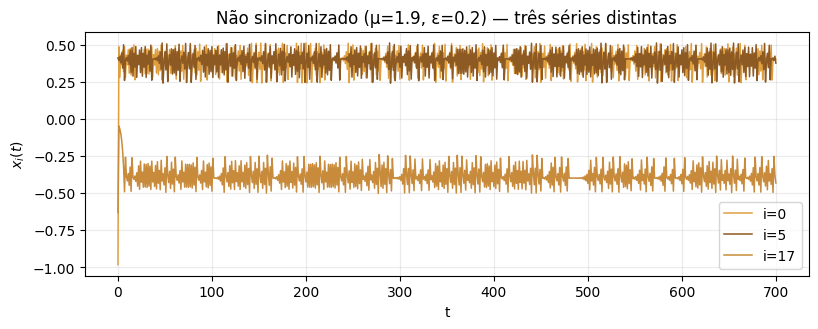

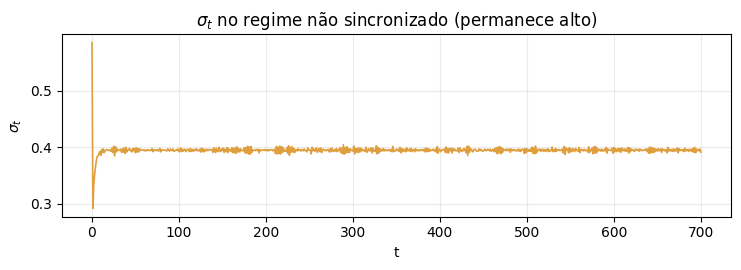

[C] λ_teo=0.641854  λ_est=0.641854  λ_perp=0.418710  (λ⊥ esperado > 0 aqui)


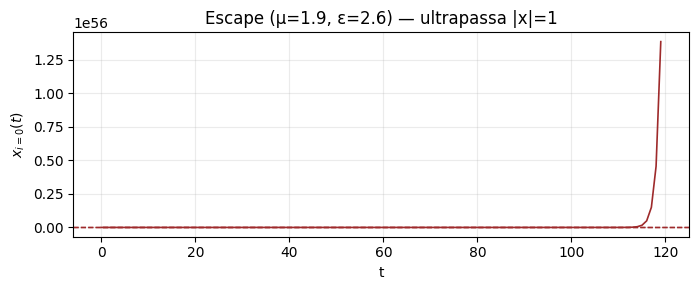

In [13]:
# ----- Não sincronizado (fora da banda) -----
MU = 1.9
EPS_NS = 0.2      # << 0.473 (limiar inferior), logo não sincroniza
N = 512
T = 700

cfg_ns = Config(N=N, eps=EPS_NS, mu=MU, seed=2027)

# IC uniformes em [-1,1] para evitar viés escondido
rng = np.random.default_rng(2027)
x0_ns = rng.uniform(-1.0, 1.0, size=N)

trajE, sysE = run_track_including_initial(cfg_ns, x0=x0_ns, T=T)

# 3 séries e σ_t
sigmas = np.std(trajE, axis=1)

fig, ax = plt.subplots(figsize=(8.2, 3.4))
for idx, c in zip([0, 5, 17], [COL_NON_SYNC, "#8e5a23", "#c88b3b"]):
    ax.plot(trajE[:, idx], lw=1.1, color=c, label=f"i={idx}")
ax.set_title(rf"Não sincronizado (μ={MU}, ε={EPS_NS}) — três séries distintas")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"E_ns_tres_series_ok.png", dpi=170); plt.show()

# σ_t (se estivesse sincronizando, cairia ~0)
fig, ax = plt.subplots(figsize=(7.6, 2.8))
ax.plot(sigmas, lw=1.2, color=COL_NON_SYNC)
ax.set_title(r"$\sigma_t$ no regime não sincronizado (permanece alto)")
ax.set_xlabel("t"); ax.set_ylabel(r"$\sigma_t$"); ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"E_ns_sigma_t.png", dpi=170); plt.show()

lam_teo, lam_est, lam_perp = lambdas(MU, EPS_NS, trajE[:, 0])
print(f"[C] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}  (λ⊥ esperado > 0 aqui)")


# Escape: para μ=1.9, uma condição de escape acontece para ε ≳ 2.579
MU = MU_MAIN
EPS_ESC = 2.60
N = 128
traj_e, sys_e = run_with_ic(mu=MU, eps=EPS_ESC, N=N, init="uniform",
                            T_burn=1, T_meas=120, seed=505)

# Mostra um índice que sai de |x|>1
xi = traj_e[:,0]
fig, ax = plt.subplots(figsize=(7.0,3.0))
ax.plot(xi, lw=1.2, color=COL_ESCAPE)
ax.axhline( 1.0, color=COL_ESCAPE, ls="--", lw=1.0)
ax.axhline(-1.0, color=COL_ESCAPE, ls="--", lw=1.0)
ax.set_xlabel("t"); ax.set_ylabel(r"$x_{i=0}(t)$")
ax.set_title(rf"Escape (μ={MU}, ε={EPS_ESC}) — ultrapassa |x|=1")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"E_escape_um_indice.png", dpi=170); plt.show()

Por fim, observamos as outras dois reigões do gráfico que não cobrimos: A região de não sincronia e a região de escape.

**Região de escape:** Nela não ná nada demais, apenas mostro que de fato para um valor muio grande $\varepsilon$ acabamos fazendo com que $x_i$ saia da região de [+1,-1] o que prejudica toda a análise dos resultados.

Agora sobre a região de fato mais importante:

**Região de não sincronia:** Observamos que, diferentemente de antes ambos $\lambda$ são positivos. Como já discutimos o que esperamos é que os modos tranversos não sejam suprimidos ao longo do tempo, fazendo com que os diferentes mapas nunca atinjam a sincronia, ou seja, mesmo para um tempo muito longo os mapas continuam seguindo caminhos diferentes. Isso acontece pelo seguinte motivo: se $|\varepsilon|\gg 1 $ a força de acoplamento fica menor, fazendo com que o mapa local domine e nenhuma tendência fosse seguida. Em nossa analogia é o seguinte: A manchete nacional não possui tanta influência sobre as casas, de modo que elas própria escolhem seus canais ou por meio de seus vizinhos e assim vários sítios são formados sem nenhuma sincronia.

**Como medir os observáveis:** Fica claro que há uma diferença muito grande entre a região síncrona e não síncrona e que há também uma transição entre essas regiões. 

O que o artigo propõe e quer focar é justamente sobre a transição entre a região síncrona e não síncrona. Para isso devemos definir uma classe de observáveis que serão uteis para nós ao longo do caminho. Isso será feito na seção abaixo, porém no gráfico acima, já podemos ver que o desvio padrão entre os mapas é importante, de modo que ele vai ser um dos observáveis para verificarmo a sincronia ou não do sistema.

## Parte D -- Definindo sincronização e variáveis $\sigma$, $s$ e M

O artigo foca, sobretudo, em observar a transição de fase entre a parte síncrona caótica e não síncrona, observando o efeito dessa transição.

Para isso, precisamos estabelecer uma variável estatística que consiga distinguir os dois estados sem ser $\mu$ e $\lambda$, que são apenas teóricos.

* **Variável** $\sigma_t$:
Uma variável fácil de ser calculada e excelente para medir a sincronia ou não dos estados é o desvio padrão instantâneo entre os mapas.

O que ele quer dizer? Pode deixar evoluir os N mapas por um tempo t e, após esse tempo, calcular o desvio padrão do conjunto $x_i^{t}$ o que nos fornece $\sigma_t$, o desvio padrão instantâneo. É claro que se os estados tados estão sincronizados todos os $x_i^{t}$ estão próximos um do outro ou, no melhor dos casos, são exatamente os mesmos, de modo que $\sigma_t$ deve tender a 0 para um tempo grande o suficiente, nos estados síncronos. Já para os não síncronos esperamos que $\sigma_t$ se estabilize em um valor maior que 0. 

$\sigma_t$ portanto será nossa variável e o critério utilizado para definir se para um dado valor de $\mu$ e $\varepsilon$ o conjunto de mapas convergiu ou não.

Outras variáveis importantes seriam as que estão ligadas a uma possível transição de fase: Ou seja, uma variável associada ao ordenamento do sistema.

Como no regime caótico há dois possível atratores, $I_+$ e $I_-$ podemos definir um parâmetro de ordem da seguinte forma:

* **Variável** $s_i^{t}$ (spin). Podemos definir uma variável de spin associada ao sinal de $x_i$; se $x_i$ é positivo essa variável é +1; se for negativo é -1, simples assim. Ou seja, teremos $s_i^{t} = sign(x_i^{t}) \in {+1,-1}$

A partir dessa construção conseguimos definir 2 outras variáveis importantes para distinguir nosso sistema:

* $M_t$: Magnetização média do sistema no tempo t, definida simplesmente pela média dos spins no tempo t. $\langle M \rangle$ pode ser entendido como o parâmetro de ordem do ssitema.

$$M_t = \frac{1}{N} \sum_i s_t^{t} $$

* Persistência $p_t:$ fração de partículas (mapas) cujo spin **nunca** mudou até o tempo t.

Já está claro nesse ponto que existe uma transição de fase entre esses regimes. O que vamos trabalhar é fixarmos $\mu$ e variarmos $\epsilon$ para observamos o comportamento de nossos observáveis nessa transição.

[D] Resumo λ e λ⊥ por ε (μ=1.9)
  ε=0.250 | estado=não sincronizado | λ=0.641854/0.641854 | λ⊥=0.354172
  ε=0.450 | estado=não sincronizado | λ=0.641854/0.641854 | λ⊥=0.044017
  ε=0.800 | estado=  sincronizado | λ=0.641854/0.641854 | λ⊥=-0.967584
  ε=1.200 | estado=  sincronizado | λ=0.641854/0.641854 | λ⊥=-0.967584


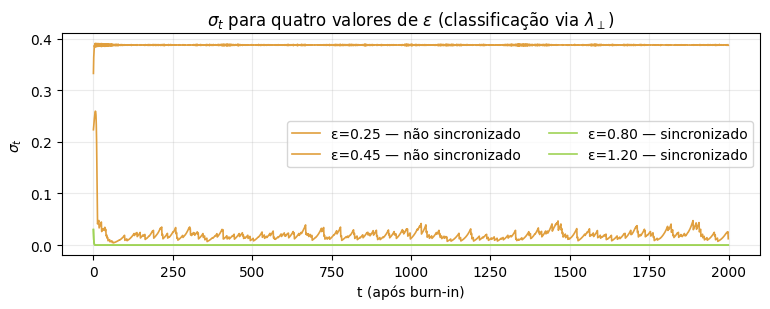

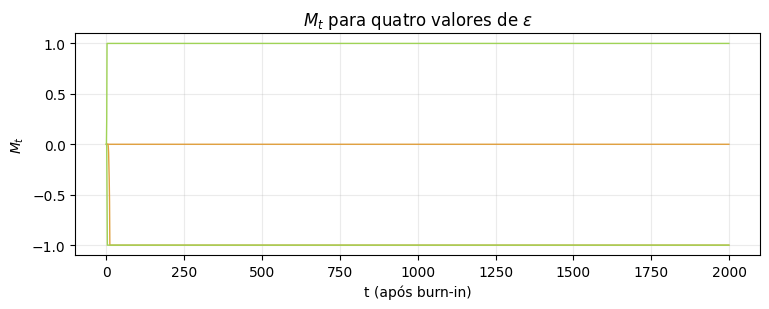

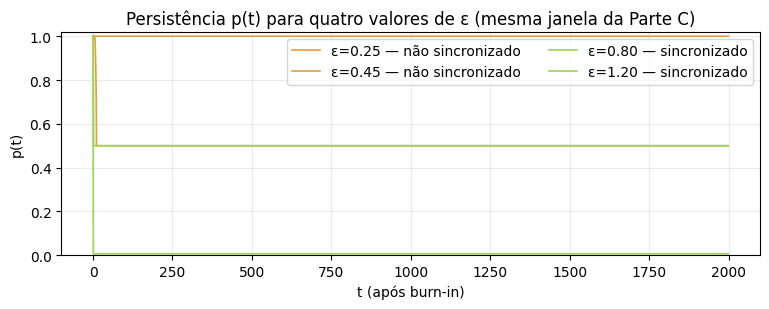

In [33]:
# ===== Parte D  =====
MU = MU_MAIN  # 1.9
# 4 eps que cobrem: não sinc. (<<0.473), perto da borda (<0.473), sinc. caótico (dentro da banda)
EPS_LIST_C = [0.25, 0.45, 0.80, 1.20]   # você pode ajustar depois; a classificação abaixo é automática
N = 10000
T_BURN, T_MEAS = 1, 2000

def classify_by_lambda_perp(mu, eps):
    lam_teo = math.log(abs(mu))
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo
    return ("sincronizado" if lam_perp < 0 else "não sincronizado"), lam_teo, lam_perp

def compute_TS(mu, eps, N, T_burn, T_meas, seed=2025):
    traj, sys = run_with_ic(mu=mu, eps=eps, N=N, init="half_half",
                            T_burn=T_burn, T_meas=T_meas, seed=seed)
    sigmas = np.std(traj, axis=1)
    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    return traj, sigmas, Ms

# roda e coleta
resC = []
for eps in EPS_LIST_C:
    traj, sigmas, Ms = compute_TS(MU, eps, N, T_BURN, T_MEAS, seed=2025+int(1000*eps))
    state, lam_teo, lam_perp = classify_by_lambda_perp(MU, eps)
    # λ_est: basta estimar uma única vez (vale para todos ε)
    lam_est = estimate_lambda_local(traj[:, 0], MU)
    resC.append({
        "eps": eps, "traj": traj, "sigmas": sigmas, "Ms": Ms,
        "state": state, "lam_teo": lam_teo, "lam_est": lam_est, "lam_perp": lam_perp
    })

# imprime resumo de λ e λ⊥
print("[D] Resumo λ e λ⊥ por ε (μ=1.9)")
for r in resC:
    print(f"  ε={r['eps']:.3f} | estado={r['state']:>14s} | λ={r['lam_teo']:.6f}/{r['lam_est']:.6f} | λ⊥={r['lam_perp']:.6f}")

# plot σ_t para os 4 ε
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(r["sigmas"], lw=1.2, color=color, label=f"ε={r['eps']:.2f} — {r['state']}")
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel(r"$\sigma_t$")
ax.set_title(r"$\sigma_t$ para quatro valores de $\varepsilon$ (classificação via $\lambda_\perp$)")
ax.grid(alpha=0.25); ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_sigma_t_quatro_eps.png", dpi=180); plt.show()

# plot M_t para os 4 ε
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(r["Ms"], lw=1.0, color=color, label=f"ε={r['eps']:.2f} — {r['state']}")
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel(r"$M_t$")
ax.set_title(r"$M_t$ para quatro valores de $\varepsilon$")
ax.grid(alpha=0.25); #ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_M_t_quatro_eps.png", dpi=180); plt.show()


# === PLotando p(t)===
from gcm.metrics import spins, persistence_curve

# p(t) para os mesmos 4 epsilons
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    # r["traj"] tem shape (T_meas, N)
    S = spins(r["traj"])                  # (T_meas, N) em {-1,+1}
    p = persistence_curve(S)              # (T_meas,)
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(p, lw=1.2, color=color,
            label=f"ε={r['eps']:.2f} — {r['state']}")

ax.set_xlabel("t (após burn-in)")
ax.set_ylabel("p(t)")
ax.set_ylim(0.0, 1.02)
ax.set_title("Persistência p(t) para quatro valores de ε (mesma janela da Parte C)")
ax.grid(alpha=0.25)
ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_p_t_quatro_eps.png", dpi=180); plt.show()


**Discussão sobre o gráfico:**

* $\sigma_t$: O que observamos no gráfico é uma intuição sobre a transição de fase: Para diferentes valores de $\varepsilon$ e  $\sigma_t$ se estabiliza em certo lugar. Note que os estados sincronizados ambos vão para $\sigma_t \approx 0$ quando o tempo é grande o suficiente e isso está de acordo com as expectativas associada ao valor de seu $\lambda_{\perp}$. Para não sincronia ainda vemos dois casos bem distintos: Primeiro um estado não sincronizado que possui $\sigma_t$ alto ao longo de todo tempo. Outro, para um $\varepsilon$ maior, a força do acoplamento global já é suficientemente grande para diminuir $\sigma_t$ consideravelmente, entretanto, ainda temos flutuações que não o fazem chegar a 0, como visto acima.

[Podemos testar para diferentes valores de $\varepsilon$ caso desejem].

* $M_t$: Nesse gráfico, com os mesmo valores, já conseguimos ver comportamentos bem distintos. Para o estado não sincronizado com $\varepsilon$ grande, $M_t$ tende a convergir para $|M|=1$, ainda que as órbitas não estejam totalmente sincronizadas. O que isso significa? Os $x_t^{i}$ tendem a adiquir um sinal global, entretanto ainda estão dessincronizados, com cada $x_i^{t}$ seguindo sua própria órbita.

No caso do estado não sincronizado com $\varepsilon$ baixo temos o resultado esperado: O parâmetro de ordem indica se encontra em 0, ou seja, o sistema se encontra desordenado.

No caso dos estados sincronizados novamente temos os resultados esperados $|M|=1$ ou seja, temos uma configuração ordenada do sistema.


* $p(t):$ O que esse gráfico nos diz é que no caso não sincronizado todos tendem a manter os mesmos spins ao longo de todo o tempo, ou seja, algúem que começou num valor negativo (positivo) de $x_i$ tende a permaneceer nesse lado ao longo da evolução temporal. Já nos outros casos, aproxidametne metade dos spins tendem a trocar de lado conforme o tempo passo indo para onde a manchete nacional (força global) atrai todos. Para $\varepsilon$ vemos um resultado ainda mais estranho, parece que todos os spins trocam de sinal ao menos uma vez rapidamente. Isso nos leva a uma série de questionamentos sobre o comportamento dos observáveis com $\varepsilon$

Esses 3 simples gráficos nos leva ao seguinte pensamento: O sistema pode estar ordenado e ao mesmo tempo não sincronizado para um certo regime de $\varepsilon$, ou ordenado e sincronizado ou até casos que possivelmente não exploramos aqui para os valores de $\varepsilon$ testados. 

Dessa forma, se mostra necessário estudarmos a fundo a variação desses parâmetros não ao longo do tempo, mas ao longo de $\varepsilon$, para um tempo muito grande (quando o sistema já estiver se estabilizado, entrado em **"equilíbrio"**).



## Parte E -- Distribuições de x para diversos $\varepsilon$

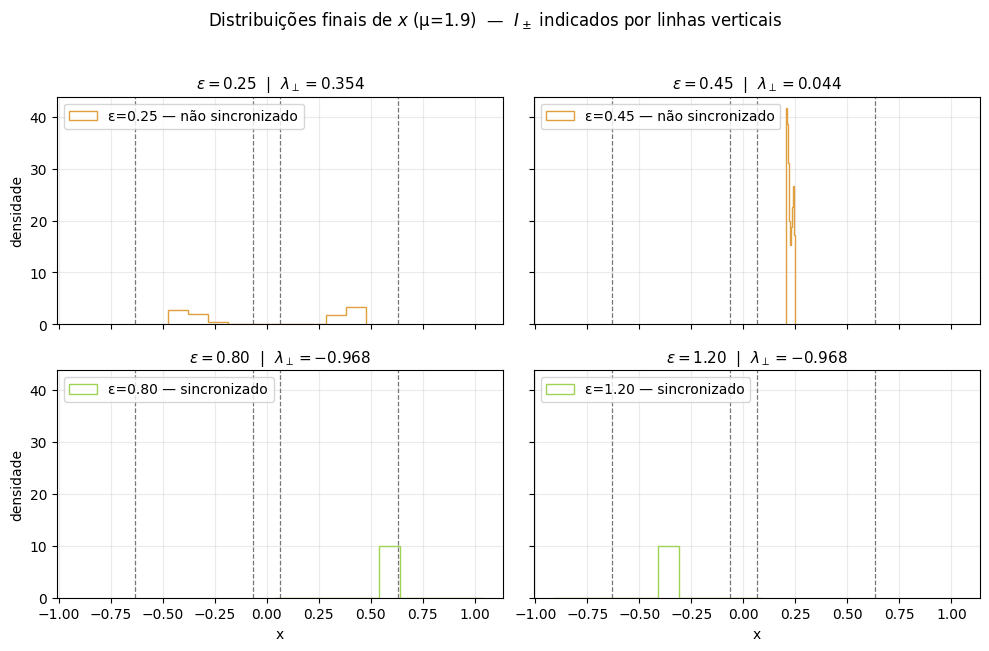

[D] λ (teo/est): 0.641854 / 0.641854
    ε=0.250 -> estado=não sincronizado | λ⊥=0.354172
    ε=0.450 -> estado=não sincronizado | λ⊥=0.044017
    ε=0.800 -> estado=  sincronizado | λ⊥=-0.967584
    ε=1.200 -> estado=  sincronizado | λ⊥=-0.967584


In [34]:
# ===== Parte E (substituir) =====
MU = MU_MAIN  # 1.9
EPS_LIST_D = EPS_LIST_C  # reaproveita os 4 ε da parte C
N = 1024
T_BURN, T_MEAS = 1200, 1200

# roda para cada ε e guarda o estado final
finals = {}
states = {}
lam_perps = {}
lam_teo = math.log(abs(MU))  # único para todos
# também registremos λ_est uma vez
lam_est_once = None

for eps in EPS_LIST_D:
    traj, sys = run_with_ic(mu=MU, eps=eps, N=N, init="half_half",
                            T_burn=T_BURN, T_meas=T_MEAS, seed=2025+int(1000*eps))
    finals[eps] = sys.x.copy()
    state, _, lam_perp = classify_by_lambda_perp(MU, eps)
    states[eps] = state
    lam_perps[eps] = lam_perp
    if lam_est_once is None:
        lam_est_once = estimate_lambda_local(traj[:,0], MU)

# intervalos I_± (fixos para MU)
i_minus, i_plus = bistable_intervals(MU)
xlines = [i_minus[0], i_minus[1], i_plus[0], i_plus[1]]

# 2x2 hist
fig, axes = plt.subplots(2, 2, figsize=(10, 6.6), sharex=True, sharey=True)
axes = axes.ravel()

for ax, eps in zip(axes, EPS_LIST_D):
    color = COL_SYNC_CHAOS if states[eps]=="sincronizado" else COL_NON_SYNC
    ax.hist(finals[eps], histtype="step", density=True, color=color, label=f"ε={eps:.2f} — {states[eps]}")
    # linhas VERTICAIS indicando I_- e I_+
    for xv in xlines:
        ax.axvline(xv, color="#777777", lw=0.9, ls="--")
    ax.set_title(rf"$\varepsilon={eps:.2f}$  |  $\lambda_\perp={lam_perps[eps]:.3f}$", fontsize=11)
    ax.grid(alpha=0.25); ax.legend(loc="upper left", frameon=True)

axes[2].set_xlabel("x"); axes[3].set_xlabel("x")
axes[0].set_ylabel("densidade"); axes[2].set_ylabel("densidade")
fig.suptitle(rf"Distribuições finais de $x$ (μ={MU})  —  $I_\pm$ indicados por linhas verticais", y=0.98)
fig.tight_layout(rect=[0,0,1,0.96]); fig.savefig(FIGS/"D_hist_x_quatro_eps_com_Ipm.png", dpi=190); plt.show()

print(f"[D] λ (teo/est): {lam_teo:.6f} / {lam_est_once:.6f}")
for eps in EPS_LIST_D:
    print(f"    ε={eps:.3f} -> estado={states[eps]:>14s} | λ⊥={lam_perps[eps]:.6f}")


**Discussão:**

Acima vemos os gráficos de densidade para cada um dos casos anteirores. Com eles entendemos melhor o que acontece na figura final. Mesmo após um tempo longo, os estados sincronizados não ficam todos juntos mesmo após um longo periodo de tempo, entretanto para $\varepsilon = 0.45$ já vemos uma concentração dos dados em torno de algum valor, mesmo com as órbitas não sincronizadas. Nos casos de sincronia, temos exatamente o que esperávamos, todos concentrado em um dado valor. No caso de não sincronia maior, há uma dispersão maior dos valores de $x_i$.